In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [158]:
from job_utils.idxpckl import Indexed_Pickle

In [161]:
root_dir = '/media/akumar/Data/nse'

In [162]:
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)
uoi = pd.read_pickle('%s/finalfinal/uoi_concat_df.dat' % root_dir)

In [9]:
import pickle

In [10]:
# Remove the parasitic index field
uoi = uoi.drop('index', axis=1)
lasso = lasso.drop('index', axis=1)
mcp = mcp.drop('index', axis=1)
scad = scad.drop('index', axis=1)
en = en.drop('index', axis=1)

# Replace with a robust index
uoi.set_index(np.arange(uoi.shape[0]), inplace=True)
lasso.set_index(np.arange(lasso.shape[0]), inplace=True)
mcp.set_index(np.arange(mcp.shape[0]), inplace=True)
scad.set_index(np.arange(scad.shape[0]), inplace=True)
en.set_index(np.arange(en.shape[0]), inplace=True)

In [11]:
# Load precalculated ss and eigenvalue bounds
with open('eigenvalue_bounds_kappa.dat', 'rb') as f:
    eigenvalue_bounds = pickle.load(f)
    ss = pickle.load(f)

In [10]:
with open('alpha_fnrfpr_case1.dat', 'rb') as f:
    alpha_datalist_case1 = pickle.load(f)
with open('alpha_fnrfpr_case2.dat', 'rb') as f:
    alpha_datalist_case2 = pickle.load(f)
with open('alpha_fnrfpr_case3.dat', 'rb') as f:
    alpha_datalist_case3 = pickle.load(f)    

In [12]:
from plotting_utils import *

In [13]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [14]:
# Recalculate the alpha_df for the ideal case
import pickle

In [15]:
sparsity = np.unique(uoi['sparsity'].values)

In [16]:
from expanded_ensemble import load_covariance

### Calculations

In [17]:
# Pre-sparsifty the beta for inverse exponential distribution and save away, as this is a time sink
sparse_beta = []
cov_idxs = np.arange(120)
for k, s in enumerate(sparsity):            
    for cov_idx in cov_idxs:
        _, cov_param = load_covariance(cov_idx)
        # take the minimum non-zero beta value
        beta = gen_beta2(500, 500, 
                         1, -1, seed=1234, distribution='normal')        
        # Sparsify beta
        beta = sparsify_beta(beta, cov_param['block_size'], s,
                             seed = cov_param['block_size'])
        sparse_beta.append({'sparsity': s, 'cov_idx': cov_idx, 'beta': beta})

In [18]:
cov_params = [] 
for cov_idx in np.arange(120):
    _, cp = load_covariance(cov_idx)
    cov_params.append(cp)

In [19]:
sparse_beta = pd.DataFrame(sparse_beta)

In [20]:
from sklearn.preprocessing import StandardScaler

In [24]:
# Eigenvalue constant
def calc_alpha_sa(cov_indices, df, rho, ss_, flag, threshold=1):
    t0 = time.time()
    alphas = np.zeros(len(cov_indices))
    etas = np.zeros(len(cov_indices))
    sa = np.zeros((len(cov_indices)))
    FNR = np.zeros((len(cov_indices)))
    FPR = np.zeros((len(cov_indices)))
    for i, cov_idx in enumerate(cov_indices):
        df_ = apply_df_filters(df, cov_idx=cov_idx)        
        cov_param = cov_params[cov_idx]
        sigma, _ = load_covariance(cov_idx)
        # Use pregenerated beta for inverse exp due to slow time for rejection sampling
        if df_.iloc[0]['betawidth'] == -1:
            sb = apply_df_filters(sparse_beta, cov_idx=cov_idx, sparsity=df.iloc[0]['sparsity'])
            beta = sb.iloc[0]['beta']
        else:
            # take the minimum non-zero beta value
            beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')                
            # Sparsify beta
            beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'], seed = cov_param['block_size'])

        beta=beta.ravel()

        alphas[i] = np.mean(rho[i] * np.min(np.abs(beta[np.nonzero(beta)[0]])**2)/ss_[i])
        
        # calculate the irrep. constant as well
        idxs = np.nonzero(beta)[0]
        if idxs.size > 0 and idxs.size < beta.size:
            for rep in range(df_.shape[0]):
                # Generate the data and calculate over reps
                _df_ = df_.iloc[rep]
                np.random.seed(int(_df_['seed']))
                X = np.random.multivariate_normal(mean = np.zeros(_df_['n_features']), cov=sigma, 
                                                  size=_df_['np_ratio'] * _df_['n_features'])
                X = StandardScaler().fit_transform(X)
                sigma_hat = 1/X.shape[0] * X.T @ X
                idxs_complement = np.setdiff1d(np.arange(sigma_hat.shape[0]), idxs)            
                C11 = sigma_hat[np.ix_(idxs, idxs)]
                C21 = sigma_hat[np.ix_(idxs_complement, idxs)]
                # Average across reps
                etas[i] += 1/df_.shape[0] * (1 - np.max(C21 @ np.linalg.inv(C11) @ np.ones(idxs.size)))
        else:
            etas[i] = np.nan
        
        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)
            FNR[i] = np.mean(df_['FNR'].values)
            FPR[i] = np.mean(df_['FPR'].values)            
        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_.iloc[cov_indices[i]]['sa'].values > threshold)/len(cov_indices[i])
           
    return alphas, etas, sa, FNR, FPR

In [25]:
np_ratios = np.unique(uoi['np_ratio'].values)
kappa = np.unique(uoi['kappa'].values)

In [27]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alphaeta_datalist = []

# Handle the ideal case first
kappa = 10
np_ratio = 16

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):      
                t0 = time.time() 
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                alpha_, eta_, sa_, FNR_, FPR_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                            ss_=ss[:, k, j, -1], flag=None) 
                alphaeta_datalist.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                        'alpha': alpha_, 'sa': sa_, 'selection_method': sm,
                                        'kappa': kappa, 'np_ratio': np_ratio, 'cov_indices': cov_indices,
                                        'FPR': FPR_, 'FNR': FNR_, 'eta': eta_})       
                print(time.time() - t0)
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

291.5335671901703


KeyboardInterrupt: 

In [34]:
with open('alphaeta_fprfnr_case3.dat', 'wb') as f:
    f.write(pickle.dumps(alphaeta_datalist))

In [24]:
alpha_datalist = pd.DataFrame(alpha_datalist_uoi)

In [25]:
with open('alpha_fnrfpr_case3.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist))

In [35]:
len(alpha_datalist_uoi)

3600

In [34]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alpha_datalist_case1 = []

# Case 1
kappa = 1
np_ratio = 4

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                alpha_, sa_, FNR_, FPR_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                            ss_=ss[:, k, j, 0], flag=None) 
                alpha_datalist_case1.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                       'alpha': alpha_, 'sa': sa_, 'selection_method': sm,
                                        'kappa': kappa, 'np_ratio': np_ratio, 'cov_indices': cov_indices,
                                        'FPR': FPR_, 'FNR': FNR_})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: UoI Lasso, bw_idx: 0, time: 45.842986
Dataframe: UoI Lasso, bw_idx: 1, time: 43.445526
Dataframe: UoI Lasso, bw_idx: 2, time: 42.762576
Dataframe: Lasso, bw_idx: 0, time: 62.253847
Dataframe: Lasso, bw_idx: 1, time: 64.695160
Dataframe: Lasso, bw_idx: 2, time: 61.761430
Dataframe: MCP, bw_idx: 0, time: 63.361611
Dataframe: MCP, bw_idx: 1, time: 66.991327
Dataframe: MCP, bw_idx: 2, time: 64.733116
Dataframe: SCAD, bw_idx: 0, time: 65.722988
Dataframe: SCAD, bw_idx: 1, time: 64.216165
Dataframe: SCAD, bw_idx: 2, time: 64.763794
Dataframe: EN, bw_idx: 0, time: 60.128032
Dataframe: EN, bw_idx: 1, time: 59.704436
Dataframe: EN, bw_idx: 2, time: 58.515568


In [37]:
# Dumbass
alpha_datalist_case1 = pd.DataFrame(alpha_datalist_uoi)
alpha_datalist_case1 = apply_df_filters(alpha_datalist_case1, kappa=1, np_ratio=4)

In [39]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alpha_datalist_case2 = []

# Case 2
kappa = 5
np_ratio = 2

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                alpha_, sa_, FNR_, FPR_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                            ss_=ss[:, k, j, 0], flag=None) 
                alpha_datalist_case2.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                       'alpha': alpha_, 'sa': sa_, 'selection_method': sm,
                                        'kappa': kappa, 'np_ratio': np_ratio, 'cov_indices': cov_indices,
                                        'FPR': FPR_, 'FNR': FNR_})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: UoI Lasso, bw_idx: 0, time: 44.535411
Dataframe: UoI Lasso, bw_idx: 1, time: 46.114095
Dataframe: UoI Lasso, bw_idx: 2, time: 43.982970
Dataframe: Lasso, bw_idx: 0, time: 61.546397
Dataframe: Lasso, bw_idx: 1, time: 62.094577
Dataframe: Lasso, bw_idx: 2, time: 63.981200
Dataframe: MCP, bw_idx: 0, time: 66.674311
Dataframe: MCP, bw_idx: 1, time: 61.370337
Dataframe: MCP, bw_idx: 2, time: 60.065854
Dataframe: SCAD, bw_idx: 0, time: 61.411647
Dataframe: SCAD, bw_idx: 1, time: 62.378955
Dataframe: SCAD, bw_idx: 2, time: 63.329239
Dataframe: EN, bw_idx: 0, time: 60.979404
Dataframe: EN, bw_idx: 1, time: 64.071753
Dataframe: EN, bw_idx: 2, time: 59.477434


In [40]:
alpha_datalist_case2 = pd.DataFrame(alpha_datalist_case2)

In [41]:
with open('alpha_fnrfpr_case2.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist_case2))

In [42]:
with open('alpha_fnrfpr_case1.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist_case1))

### Plotting

In [27]:
from collections import OrderedDict

##### FPR inspection

Text(0.5, 0.98, 'BIC Selection')

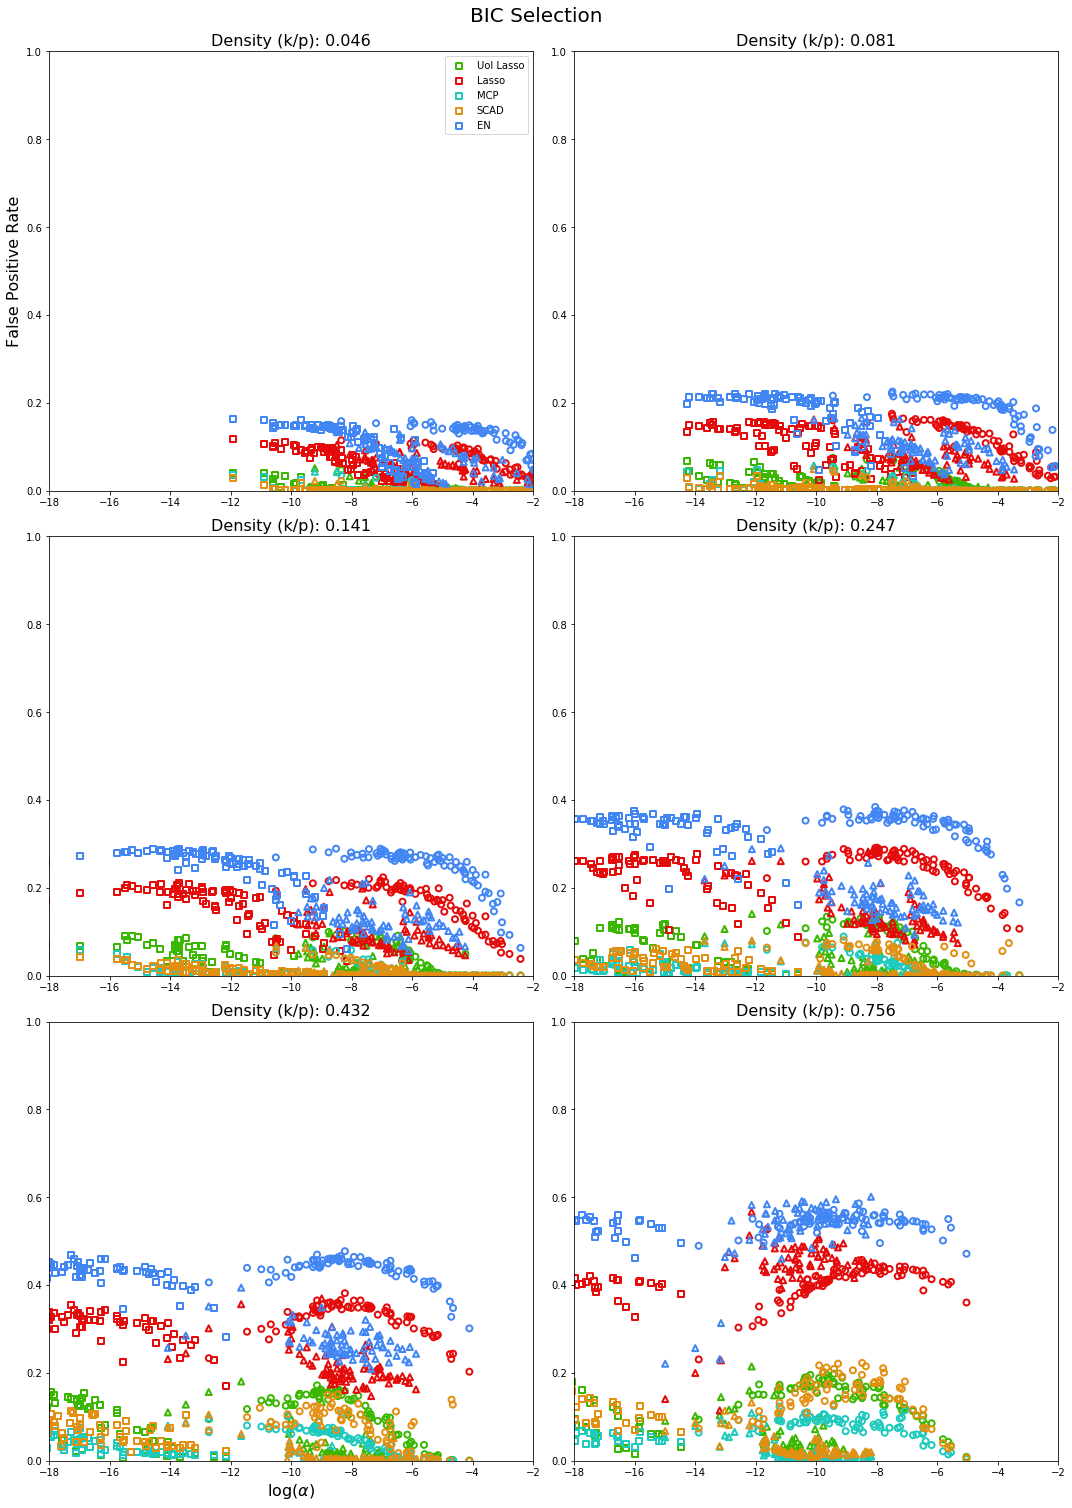

In [29]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FPR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

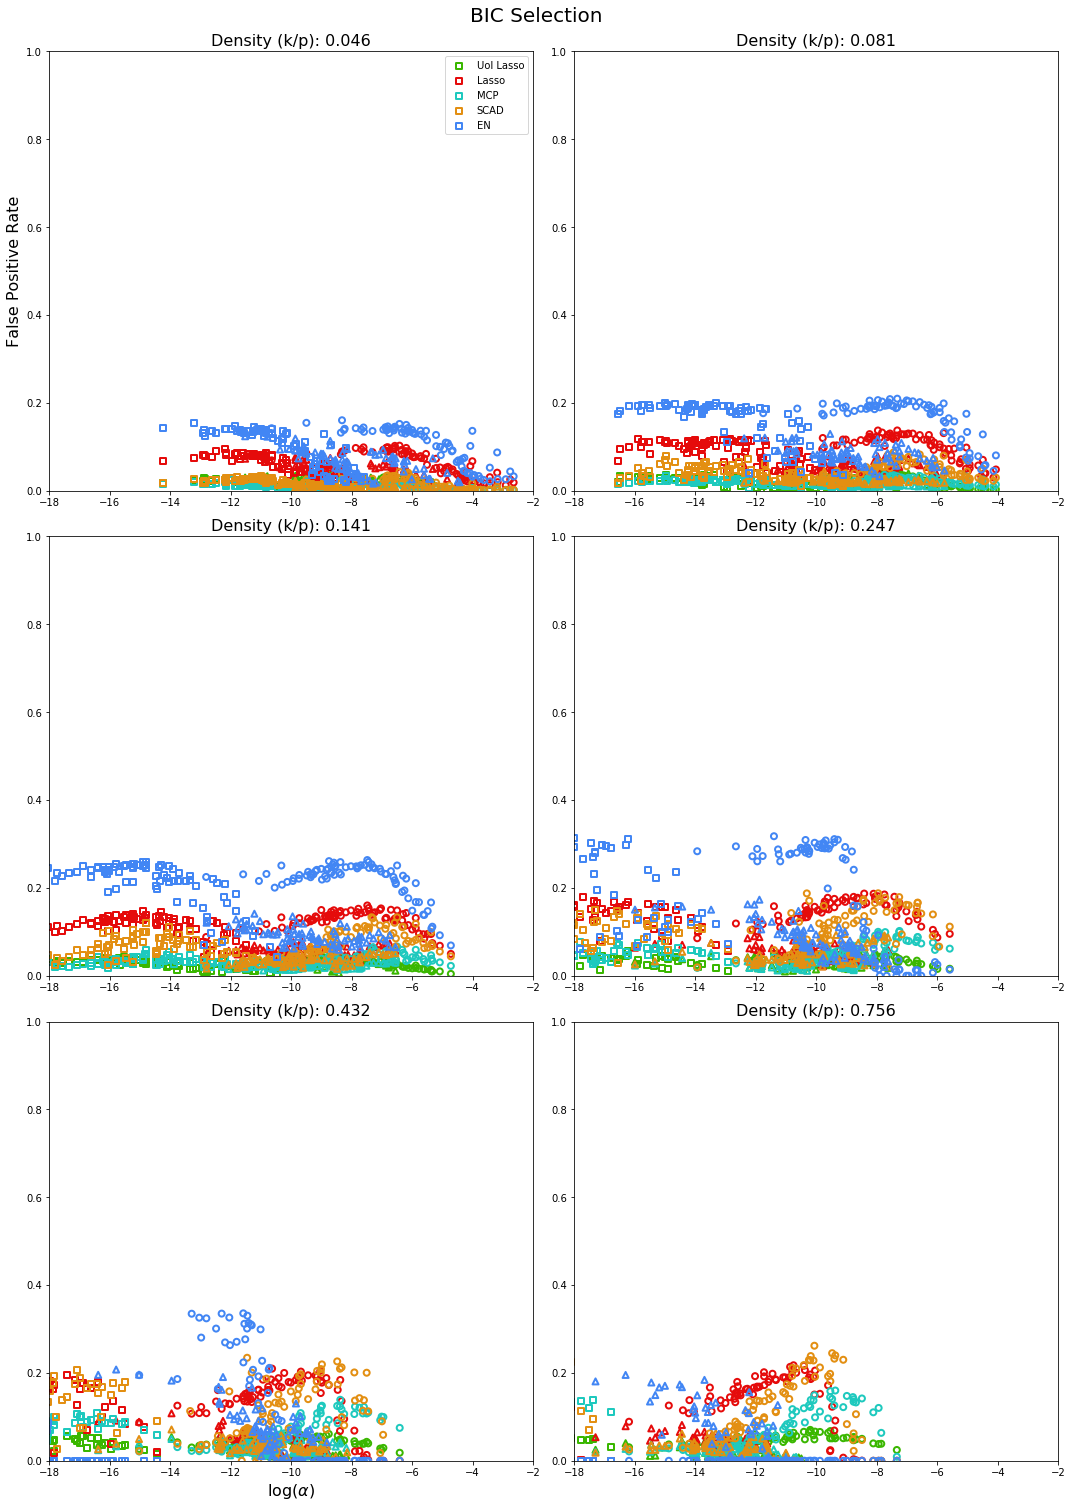

In [43]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist_case1, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FPR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

#### FNR case 3

Text(0.5, 0.98, 'BIC Selection')

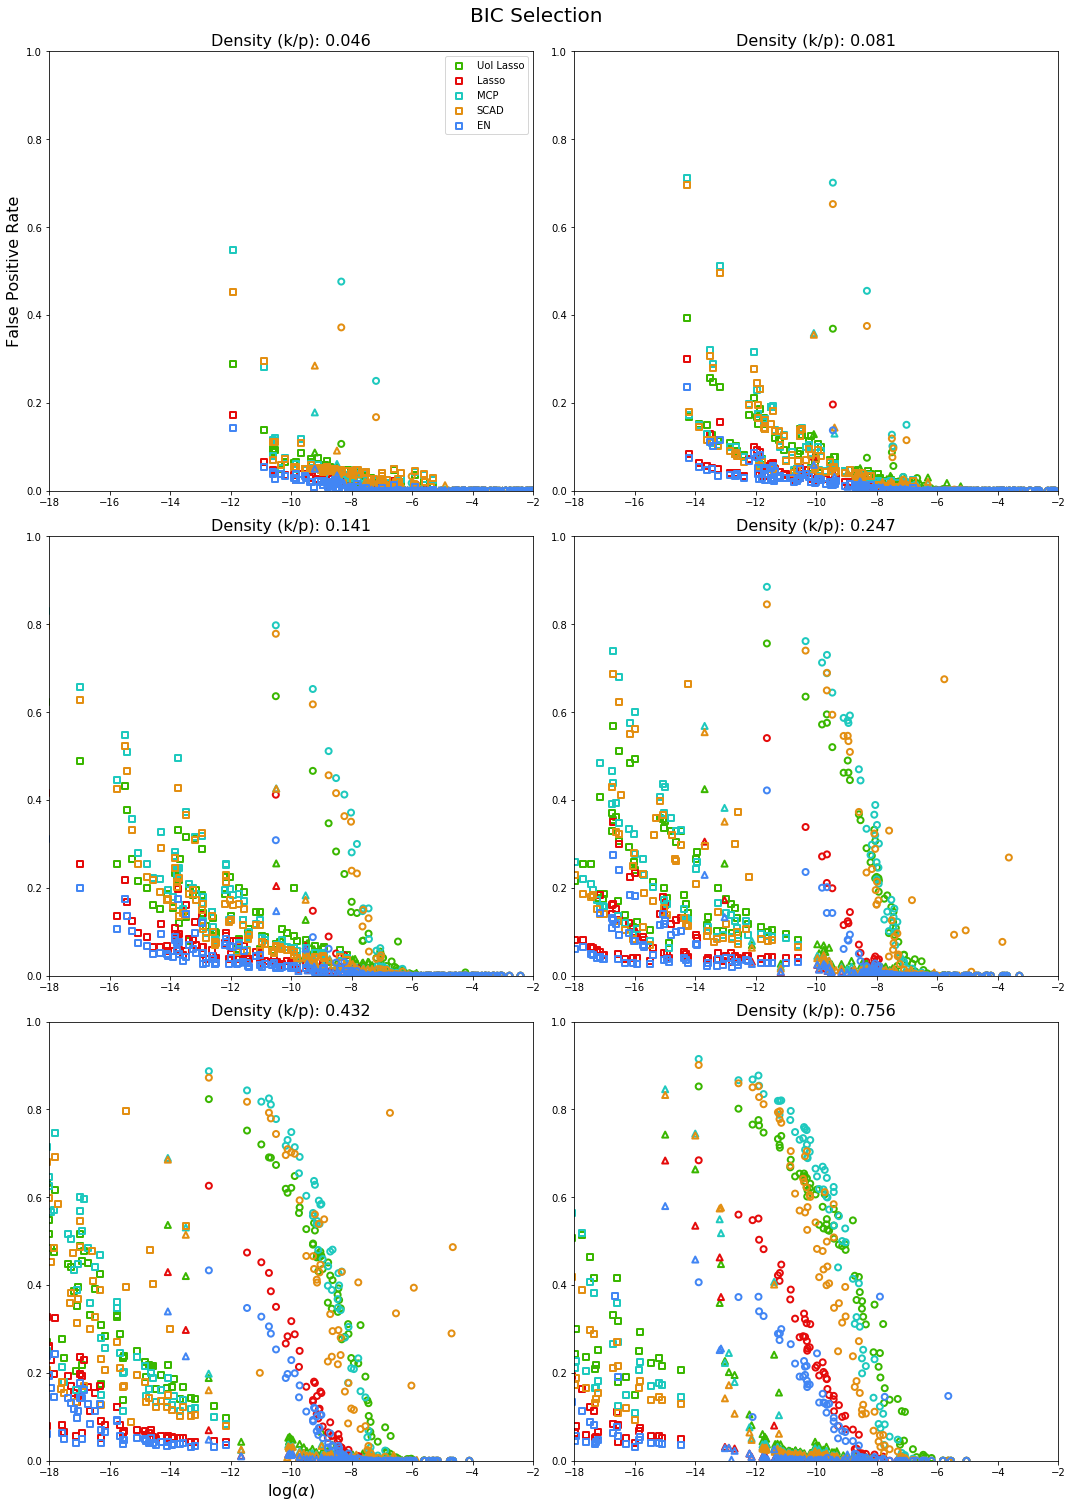

In [30]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

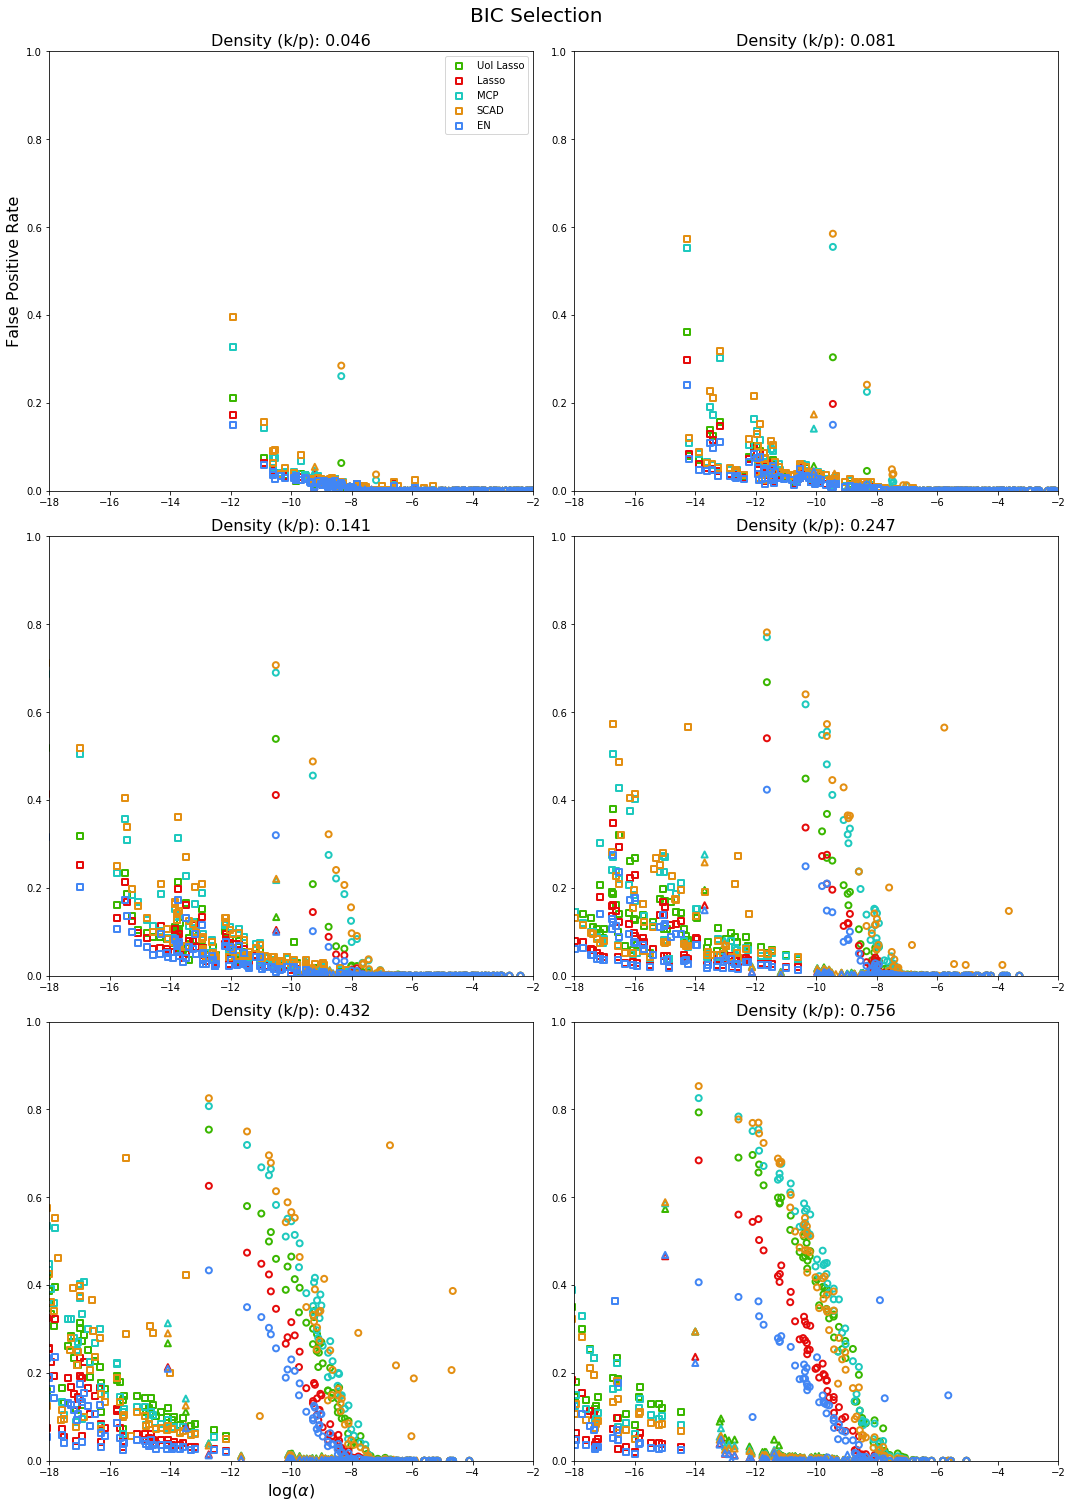

In [31]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'AIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

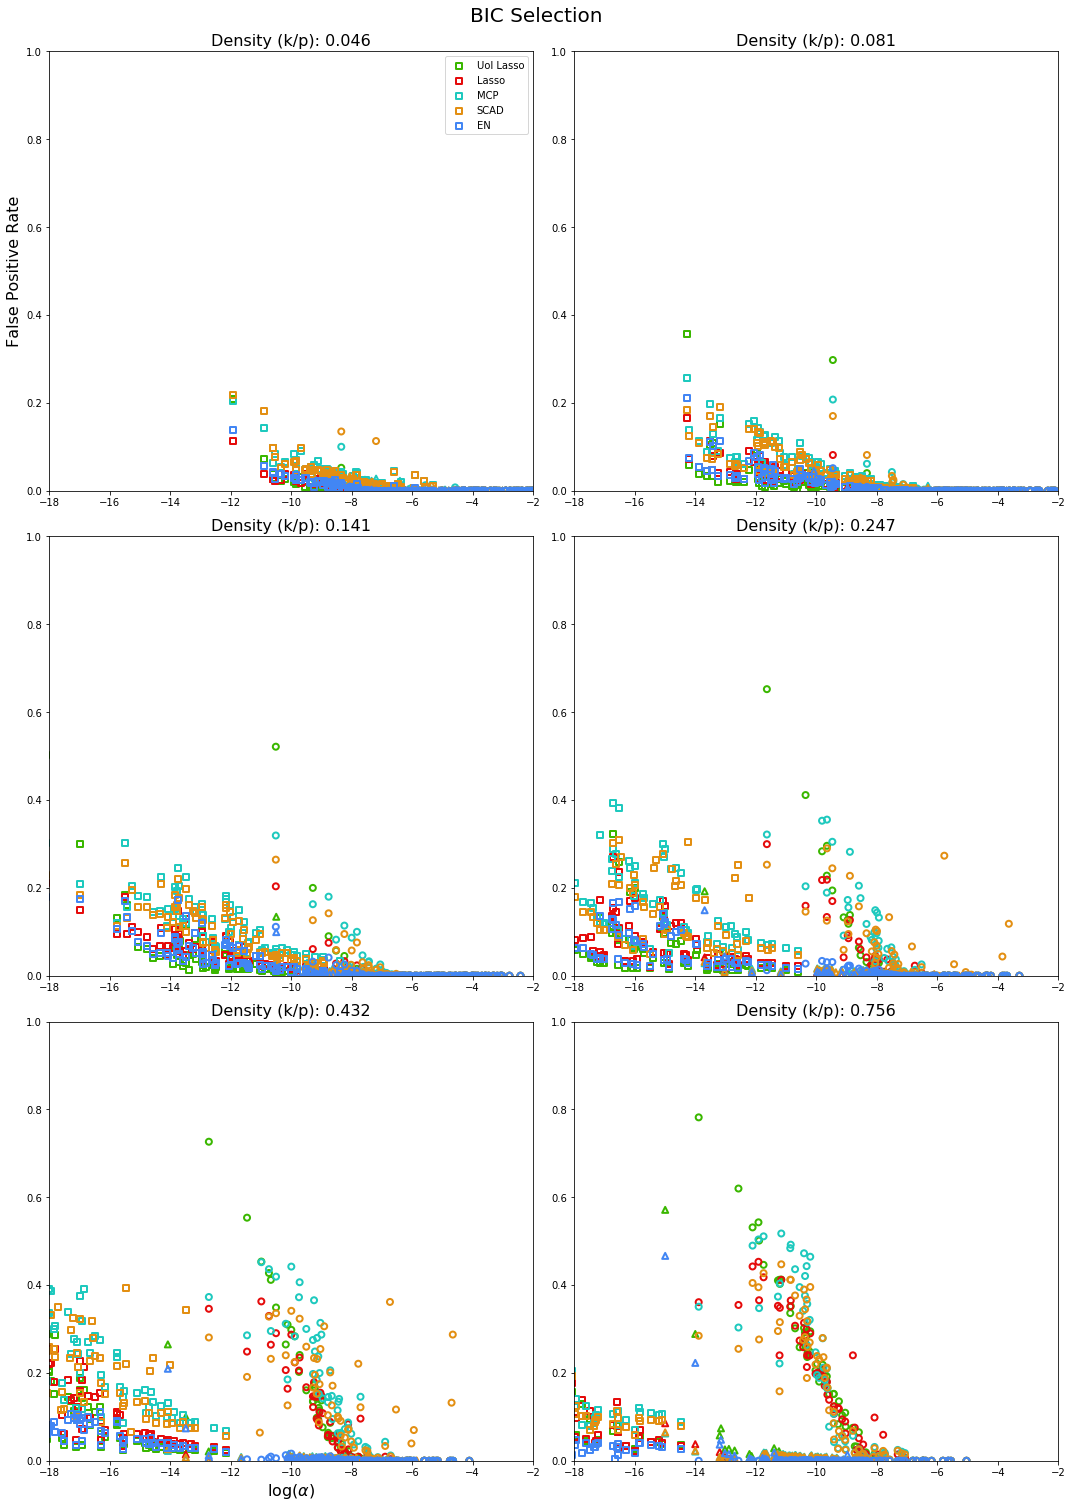

In [32]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'CV'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

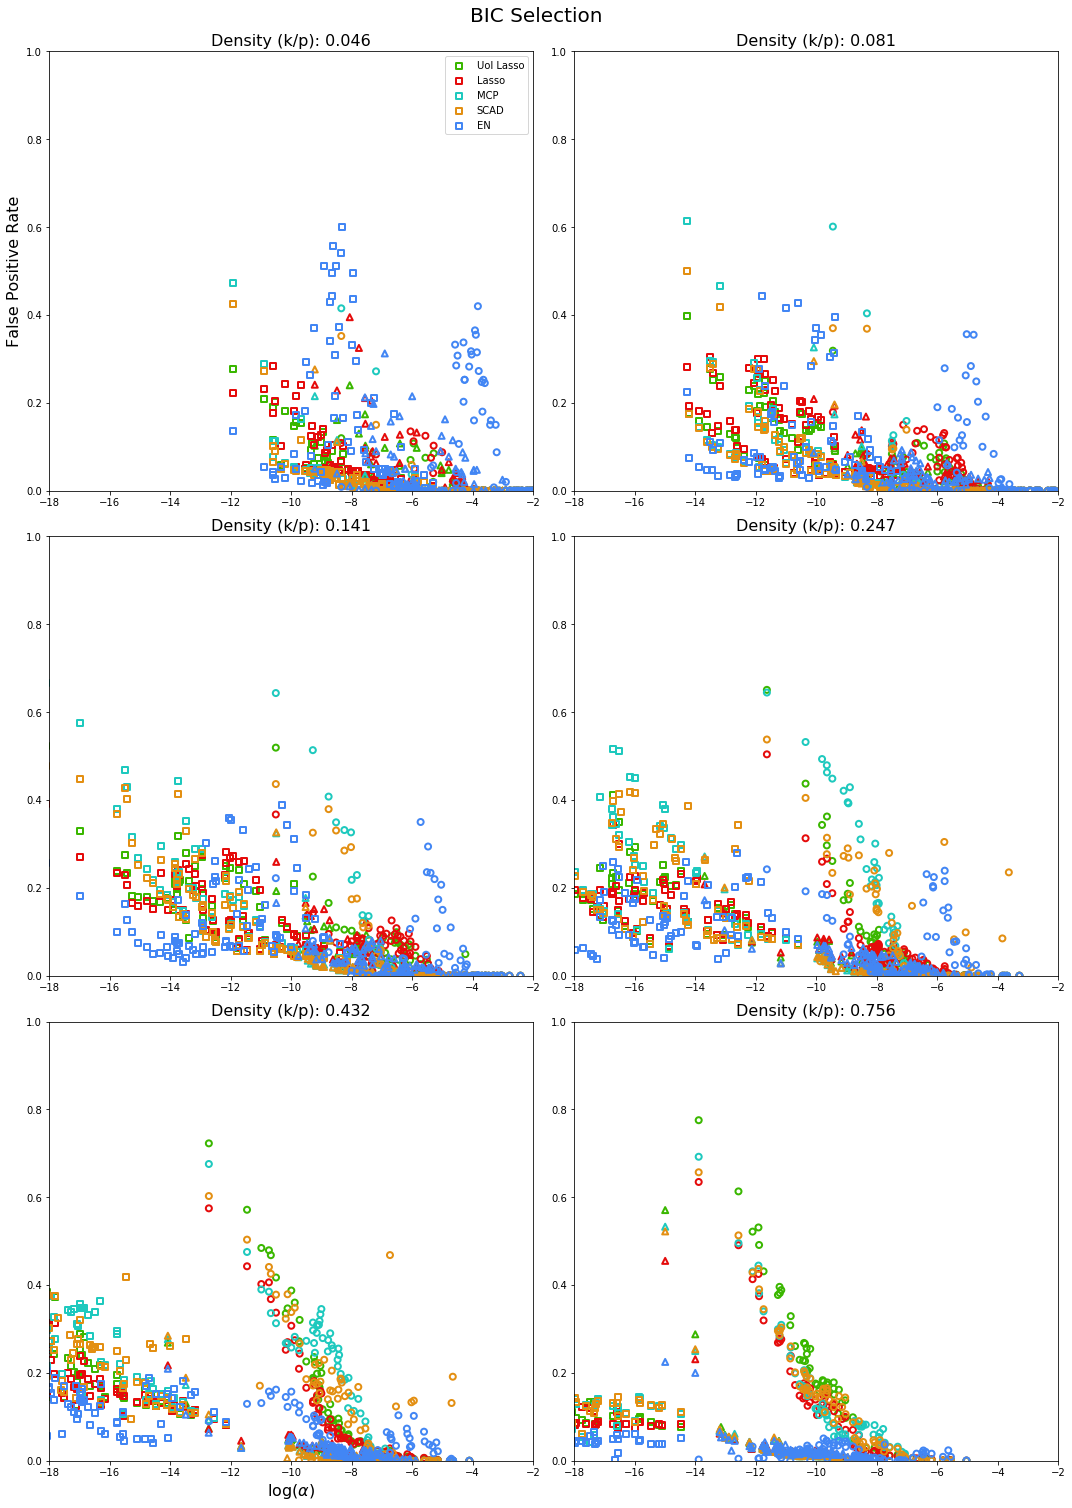

In [33]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'oracle'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

#### FNR cases 1 and 2

Text(0.5, 0.98, 'BIC Selection')

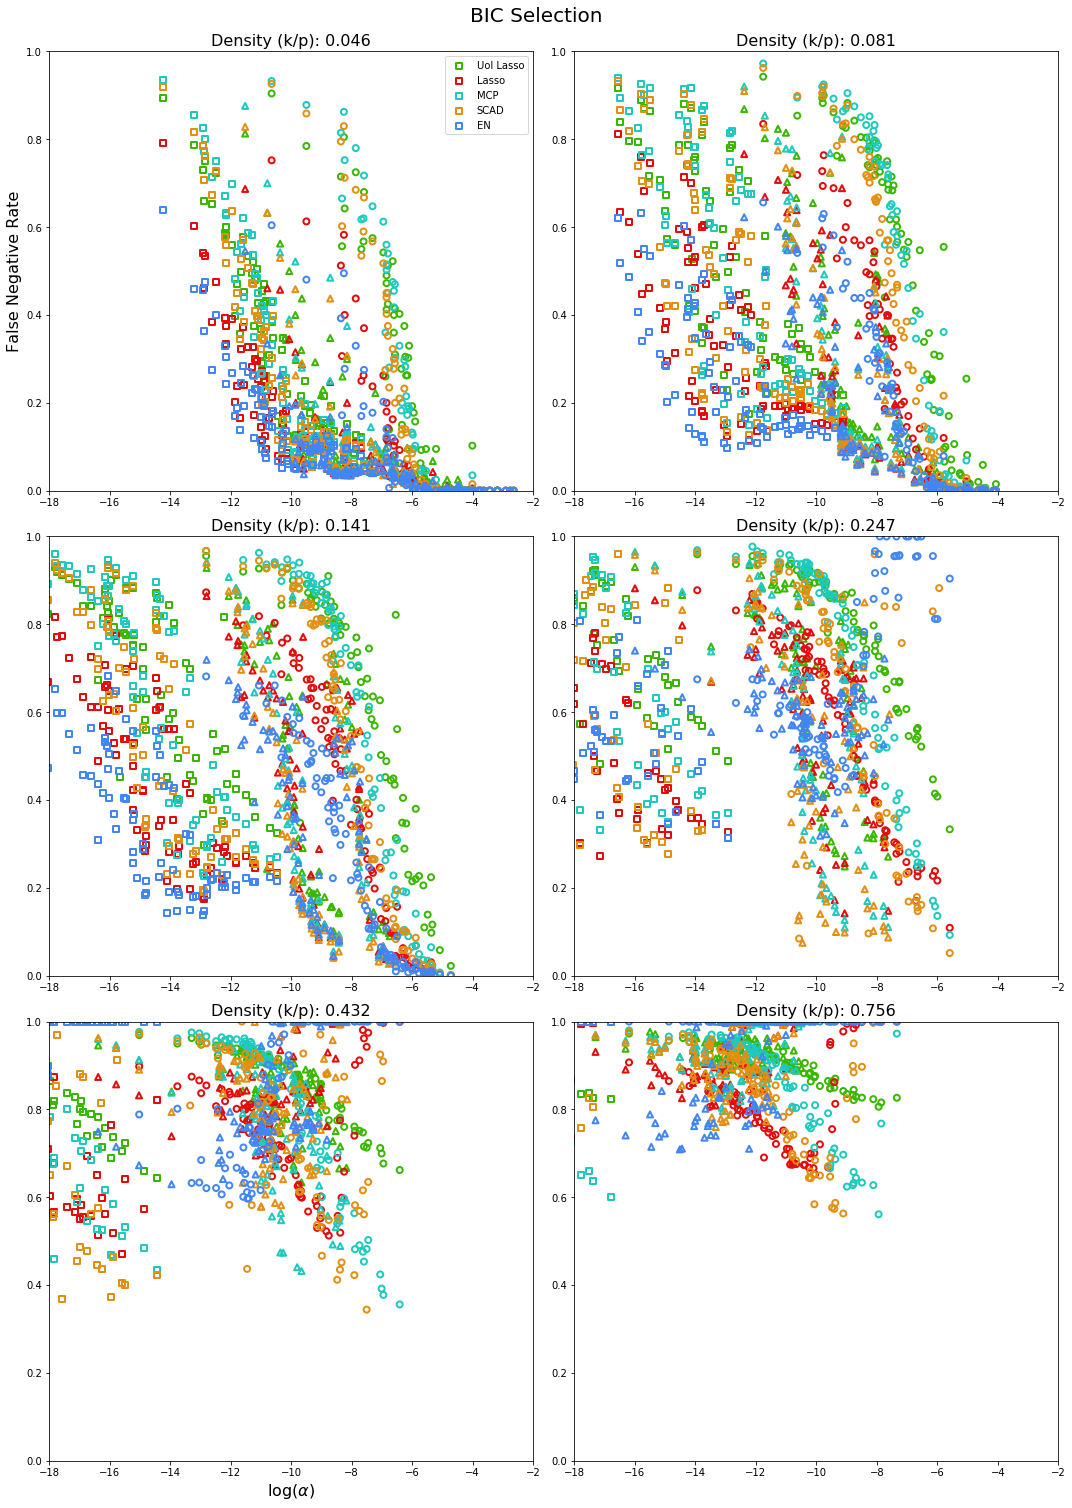

In [45]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 4
kappa = 1
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist_case1, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Negative Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

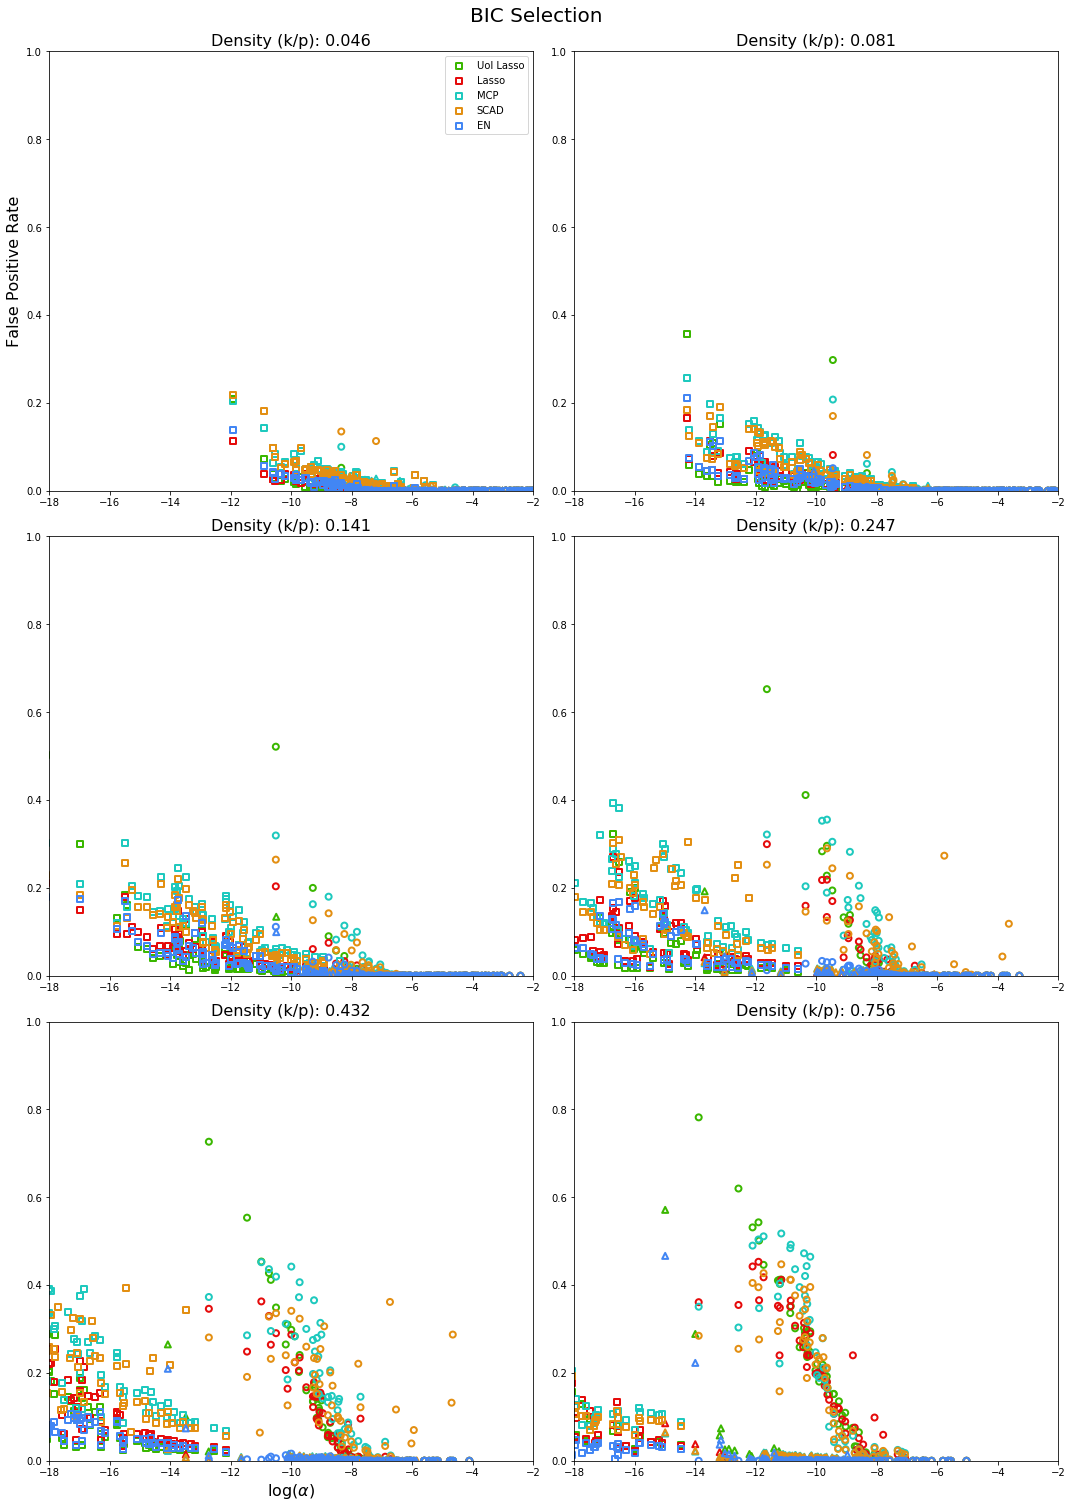

In [46]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'CV'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

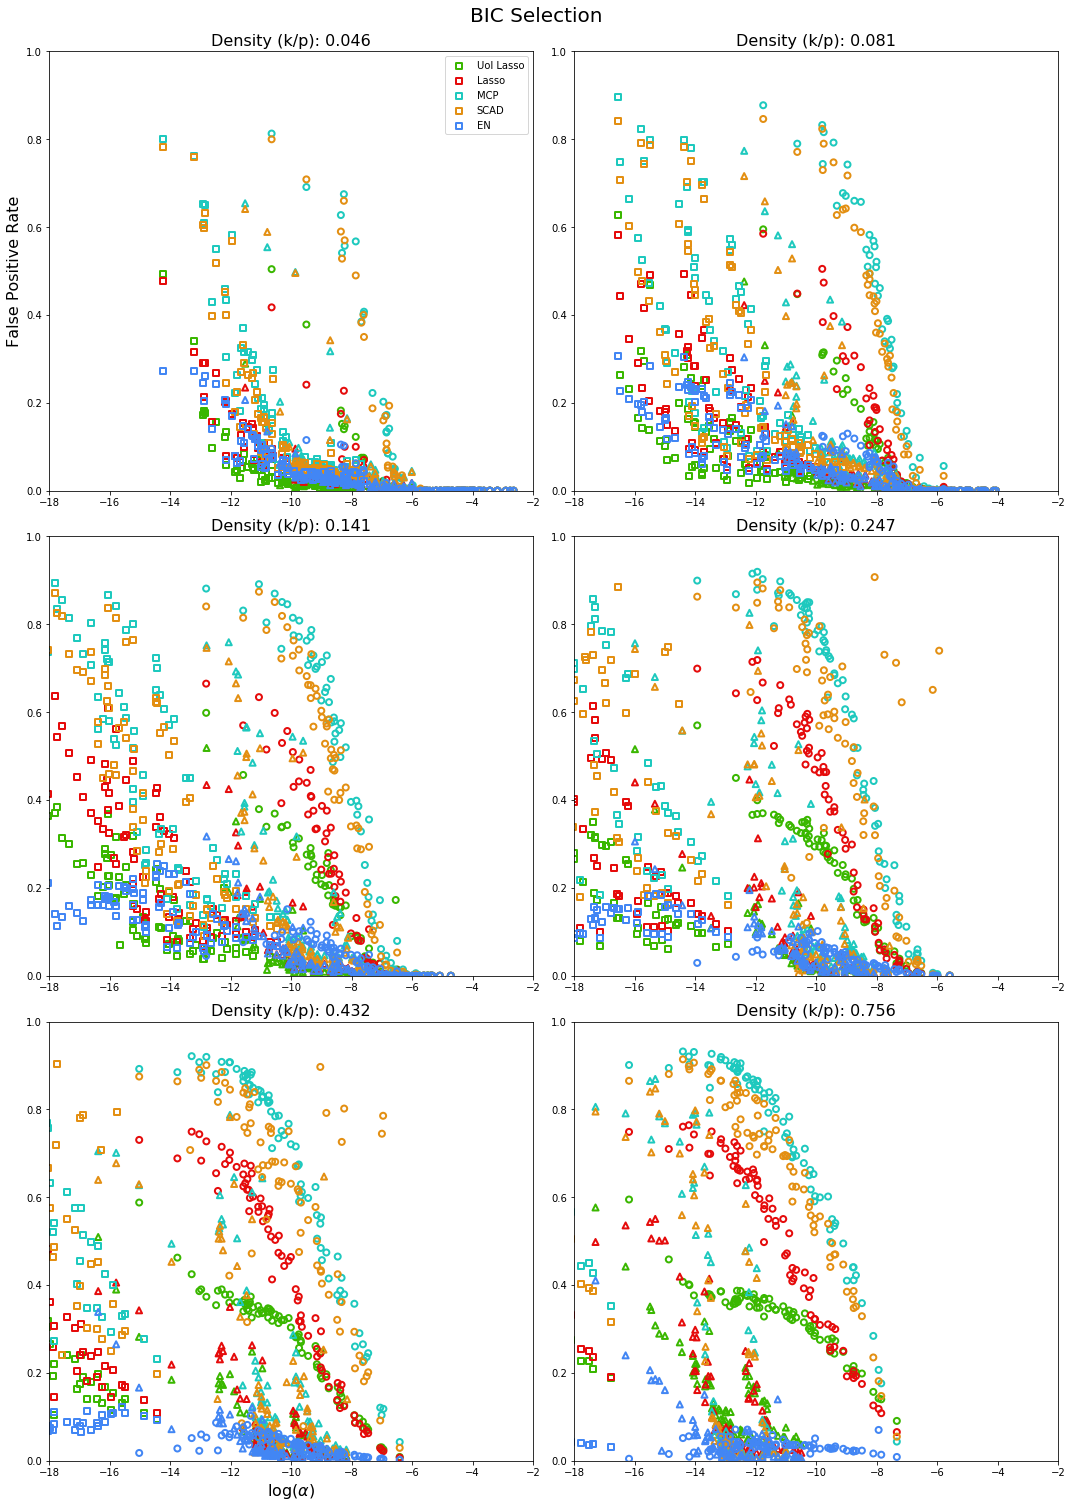

In [47]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'CV'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist_case2, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

### Fitting functions for summary statistics

In [11]:
from sigmoid import Fit_and_Select

In [12]:
list(alpha_datalist_case3.keys())

['df_name',
 'betawidth',
 'sparsity',
 'alpha',
 'sa',
 'selection_method',
 'kappa',
 'np_ratio',
 'cov_indices',
 'FPR',
 'FNR']

In [104]:
# Case 3, cleanest looking data
sigmoid_exp_df = []
for i, sm in enumerate(np.unique(alpha_datalist_case3['selection_method'].values)):
    for j, bw in enumerate(np.unique(alpha_datalist_case3['betawidth'].values)):
        for k, s in enumerate(np.unique(alpha_datalist_case3['sparsity'].values)):
            for l, df in enumerate(np.unique(alpha_datalist_case3['df_name'].values)):
                
                adf = apply_df_filters(alpha_datalist_case3, selection_method=sm, betawidth=bw,
                                       sparsity=s, df_name = df)
                
                assert(adf.shape[0] == 1)
                model = Fit_and_Select()
                
                # Filter out nans and alpha
                xx = np.log(adf.iloc[0]['alpha'][np.isfinite(adf.iloc[0]['alpha'])])
                yy = adf.iloc[0]['FNR'][np.isfinite(adf.iloc[0]['alpha'])]
                if yy.size == 0:
                    continue
                else:
                    model.fit(xx, yy)
                    # Co-plotting inspection
                    if model.model_ == 'exp' and model.score_ > 0.9 and k > 1:
                        # pdb.set_trace()
                        pass
                    sigmoid_exp_df.append({'selection_method': sm, 'betawidth': bw, 'sparsity': s,
                                           'df_name': df, 'kappa': adf.iloc[0]['kappa'],
                                           'np_ratio': adf.iloc[0]['np_ratio'],
                                           'coef': model.coef_, 'model' : model, 'mtype': model.model_,
                                           'score' : model.score_})                

In [61]:
inspection = pd.DataFrame(sigmoid_exp_df)

In [62]:
# Co-plot a few of the exponentials to make sure that we have parameterized correctly

# High predictive score
high_scorers = inspection.loc[inspection['score'] > 0.9]

> <ipython-input-68-d84447766b6d>(21)<module>()
-> a.plot(xx, high_scorer['model'].predict(xx), 'r')
(Pdb) yy_hat
array([2.17112724e+10, 2.28749759e+09, 1.17989302e+09, 8.63020800e+08,
       6.64359045e+08, 5.45998097e+08, 2.39988739e+08, 2.29123225e+08,
       2.09789617e+08, 1.69070460e+08, 1.07870215e+08, 1.05072989e+08,
       7.66460372e+07, 7.64323763e+07, 5.83062551e+07, 5.72957976e+07,
       5.28829299e+07, 5.15933350e+07, 4.97922389e+07, 4.90327347e+07,
       4.88512108e+07, 4.41126706e+07, 4.29825365e+07, 3.53865947e+07,
       3.47717448e+07, 2.90996350e+07, 2.47247869e+07, 2.34519259e+07,
       1.89940026e+07, 1.84168829e+07, 1.77512472e+07, 1.58700910e+07,
       1.42071731e+07, 1.33318243e+07, 1.19290826e+07, 1.19090202e+07,
       8.86339923e+06, 7.51845886e+06, 7.17983537e+06, 6.76935466e+06,
       6.39698434e+06, 5.18597360e+06, 3.38976870e+06, 2.95574143e+06,
       2.70390454e+06, 2.03685918e+06, 2.02201172e+06, 2.01804636e+06,
       1.76462181e+06, 1.64946764e

BdbQuit: 

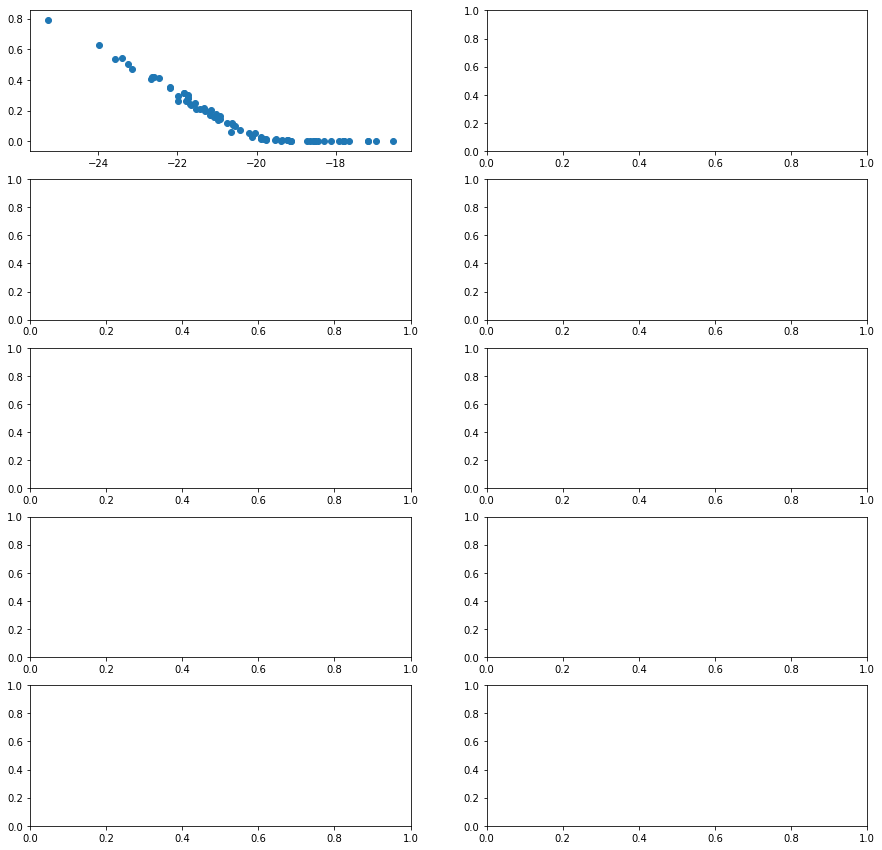

In [68]:
# Choose 10 at random

rand_choice = np.random.choice(np.arange(high_scorers.shape[0]), 10)

fig, ax = plt.subplots(5, 2, figsize=(15, 15))
for i, rc in enumerate(rand_choice):
    a = ax[np.unravel_index(i, (5, 2))]
    high_scorer = high_scorers.iloc[rc]
    # Find the corresponding set of scatter points in alpha datalist
    reference = apply_df_filters(alpha_datalist_case3, selection_method=high_scorer['selection_method'],
                                 betawidth=high_scorer['betawidth'], sparsity=high_scorer['sparsity'],
                                 df_name = high_scorer['df_name'])
    xx = np.log(adf.iloc[0]['alpha'][np.isfinite(adf.iloc[0]['alpha'])])
    yy = adf.iloc[0]['FNR'][np.isfinite(adf.iloc[0]['alpha'])]

    yy = yy[np.argsort(xx)]
    xx = np.sort(xx)
    a.scatter(xx, yy)
    yy_hat = high_scorer['model'].predict(xx)
    pdb.set_trace()
    a.plot(xx, high_scorer['model'].predict(xx), 'r')
    a.set_ylim([0, 1])

In [105]:
for i, sm in enumerate(np.unique(alpha_datalist_case2['selection_method'].values)):
    for j, bw in enumerate(np.unique(alpha_datalist_case2['betawidth'].values)):
        for k, s in enumerate(np.unique(alpha_datalist_case2['sparsity'].values)):
            for l, df in enumerate(np.unique(alpha_datalist_case2['df_name'].values)):
                
                adf = apply_df_filters(alpha_datalist_case2, selection_method=sm, betawidth=bw,
                                       sparsity=s, df_name = df)
                
                assert(adf.shape[0] == 1)
                model = Fit_and_Select()
                
                # Filter out nans and alpha
                xx = np.log(adf.iloc[0]['alpha'][np.isfinite(adf.iloc[0]['alpha'])])
                yy = adf.iloc[0]['FNR'][np.isfinite(adf.iloc[0]['alpha'])]
                if yy.size == 0:
                    continue
                else:
                    model.fit(xx, yy)
                    # Co-plotting inspection
                    sigmoid_exp_df.append({'selection_method': sm, 'betawidth': bw, 'sparsity': s,
                                           'df_name': df, 'kappa': adf.iloc[0]['kappa'],
                                           'np_ratio': adf.iloc[0]['np_ratio'],
                                           'coef': model.coef_, 'model' : model, 'mtype': model.model_,
                                           'score' : model.score_})

In [106]:
for i, sm in enumerate(np.unique(alpha_datalist_case1['selection_method'].values)):
    for j, bw in enumerate(np.unique(alpha_datalist_case1['betawidth'].values)):
        for k, s in enumerate(np.unique(alpha_datalist_case1['sparsity'].values)):
            for l, df in enumerate(np.unique(alpha_datalist_case1['df_name'].values)):
                
                adf = apply_df_filters(alpha_datalist_case1, selection_method=sm, betawidth=bw,
                                       sparsity=s, df_name = df)
                
                assert(adf.shape[0] == 1)
                model = Fit_and_Select()
                
                # Filter out nans and alpha
                xx = np.log(adf.iloc[0]['alpha'][np.isfinite(adf.iloc[0]['alpha'])])
                yy = adf.iloc[0]['FNR'][np.isfinite(adf.iloc[0]['alpha'])]
                if yy.size == 0:
                    continue
                else:
                    model.fit(xx, yy)

                    sigmoid_exp_df.append({'selection_method': sm, 'betawidth': bw, 'sparsity': s,
                                           'df_name': df, 'kappa': adf.iloc[0]['kappa'],
                                           'np_ratio': adf.iloc[0]['np_ratio'],
                                           'coef': model.coef_, 'model' : model, 'mtype': model.model_,
                                           'score' : model.score_})


In [107]:
sigmoid_exp_df = pd.DataFrame(sigmoid_exp_df)

In [108]:
sigmoid_models = apply_df_filters(sigmoid_exp_df, mtype='sig')

In [109]:
sigmoid_models.shape

(3687, 10)

(array([ 121.,  210.,  226.,  134.,  183.,  284.,  376.,  502.,  306.,
        1345.]),
 array([1.11022302e-16, 9.99999999e-02, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 6.99999999e-01,
        7.99999999e-01, 8.99999999e-01, 9.99999999e-01]),
 <a list of 10 Patch objects>)

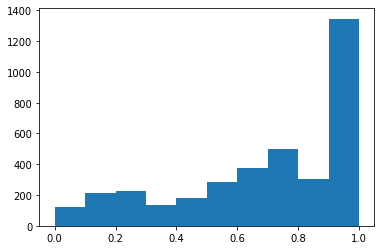

In [110]:
plt.hist(sigmoid_models['score'].values)

In [99]:
np.unique(alpha_datalist_case1['sparsity'].values)

array([0.02      , 0.02644752, 0.03497357, 0.04624822, 0.06115754,
       0.08087327, 0.10694488, 0.14142136, 0.18701223, 0.2473005 ,
       0.32702428, 0.4324491 , 0.57186037, 0.7562145 , 1.        ])

In [112]:
# Inspect parameterization
desired_case = apply_df_filters(sigmoid_exp_df, selection_method='BIC', df_name='MCP', 
                                sparsity=np.unique(alpha_datalist_case1['sparsity'].values)[9],
                                betawidth=0.1, kappa=5, np_ratio=2)

In [17]:
# Let's plot the summary statistics in a simialr way to the SA

# For a fixed case, for each selection method make a subpanel that plots, as a function of sparsity:
# the transition point for each algorithm (if it exists)
# the sensitivity (if it exists)

In [116]:
selection_methods = ['BIC', 'AIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']

In [19]:
# Also need to be sensitive to the betawidth, as each betawidth behaves separately

In [117]:
betawidth = np.unique(sigmoid_exp_df['betawidth'].values)

In [118]:
df_names = np.unique(sigmoid_exp_df['df_name'].values)

In [119]:
sigmoid_exp_df.iloc[0:5]['coef'].values[0]

[nan, nan, nan, 0.0]

In [120]:
df_names

array(['EN', 'Lasso', 'MCP', 'SCAD', 'UoI Lasso'], dtype=object)

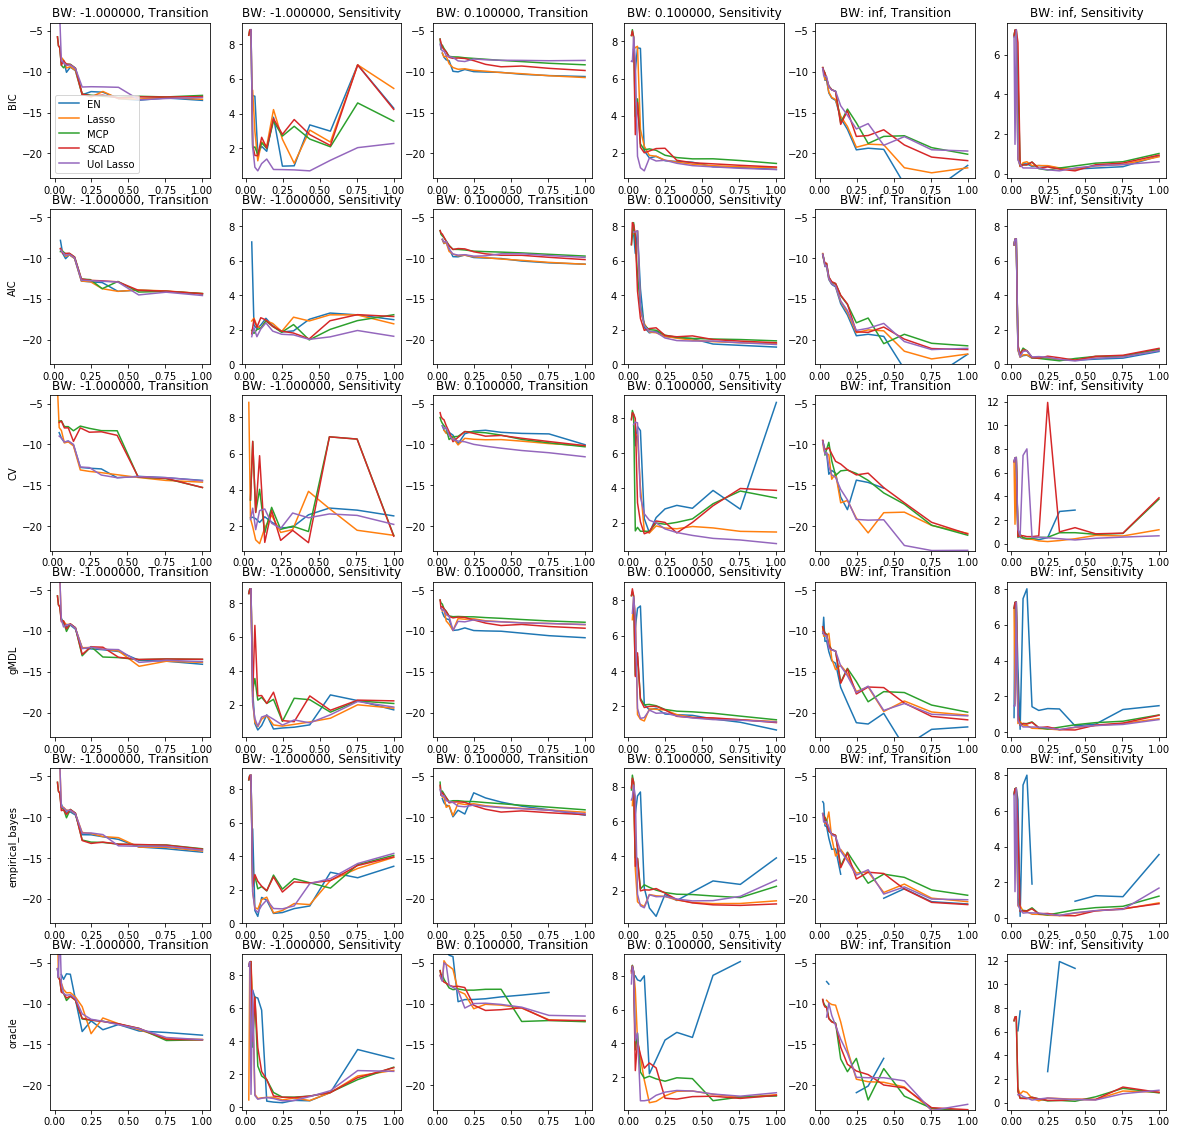

In [124]:
# Case 3
fig, ax = plt.subplots(6, 6, figsize=(20, 20))

kappa = 10
np_ratio = 16

for i, sm in enumerate(selection_methods):
    for j, bw in enumerate(betawidth):        
        for k, df in enumerate(df_names):
            df_ = apply_df_filters(sigmoid_exp_df, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                       betawidth=bw, df_name=df)
            xx = df_['sparsity'].values
            yy = np.array([df_['coef'].values[idx][2] for idx in range(df_.shape[0])])
            ax[i, 2*j].plot(xx, yy, label=df)
            ax[i, 2*j].set_title('BW: %f, Transition' % bw)

            yy = np.array([df_['coef'].values[idx][1] for idx in range(df_.shape[0])])
            ax[i, 2*j + 1].plot(xx, yy)
            ax[i, 2*j + 1].set_title('BW: %f, Sensitivity' % bw)
            if i == 0 and j == 0:
                ax[i, 2 *j].legend()
            if j == 0:
                ax[i, 2 * j].set_ylabel(sm)             
            
            # Set consistent scales across plots
            ax[i, 2*j].set_ylim([-23, -4])
            ax[1, 2*j + 1].set_ylim([0, 9])

In [30]:
# Case 3 takeaways

# Transition points of false negative rates are strongly modulated by the underlying model density 
# and the beta distribution. See the difference between the first, third and fifth columns. Also note the
# difference in behavior of Elastic Net for the bw 0.1 distribution and its erratic behavior for the uniform
# coefficient distribution

# The sensitivity of algorithms to correlations spikes dramatically in the sparsest models, falls to a floor
# that is relatively independent of the underlying model density, although Elastic Net has erratic behavior
# here

# Interestingly, the behavior is consistent across all model selection strategies, pointing to either 
# fundamental limitations or methodological details

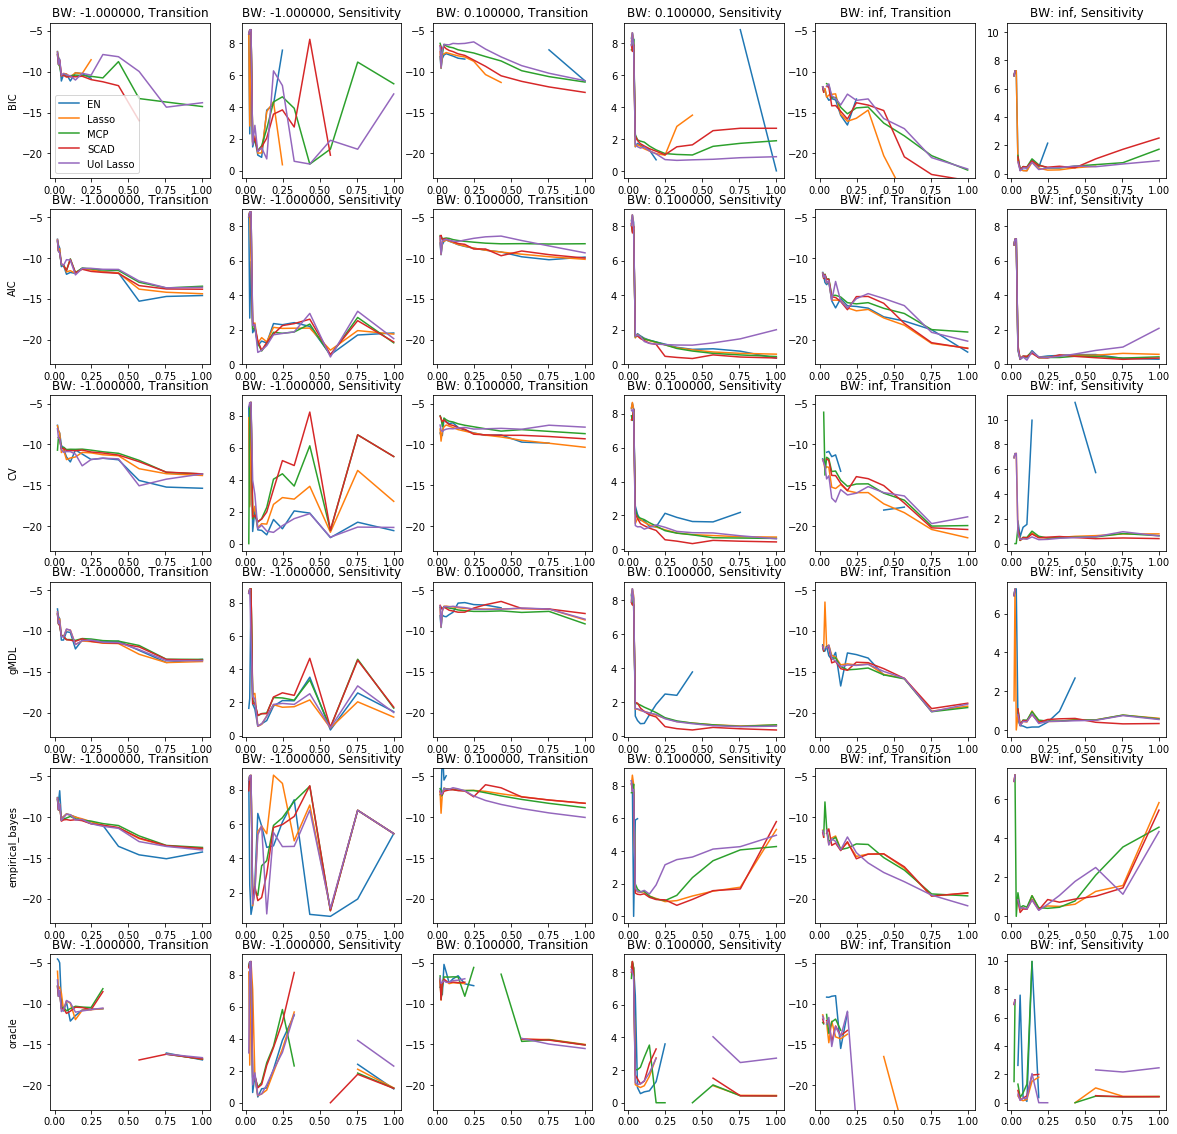

In [125]:
# Case 1
fig, ax = plt.subplots(6, 6, figsize=(20, 20))

kappa = 1
np_ratio = 4

for i, sm in enumerate(selection_methods):
    for j, bw in enumerate(betawidth):        
        for k, df in enumerate(df_names):
            df_ = apply_df_filters(sigmoid_exp_df, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                       betawidth=bw, df_name=df)
            xx = df_['sparsity'].values
            yy = np.array([df_['coef'].values[idx][2] for idx in range(df_.shape[0])])
            ax[i, 2*j].plot(xx, yy, label=df)
            yy = np.array([df_['coef'].values[idx][1] for idx in range(df_.shape[0])])
            ax[i, 2*j + 1].plot(xx, yy)
            ax[i, 2*j].set_title('BW: %f, Transition' % bw)

            ax[i, 2*j + 1].set_title('BW: %f, Sensitivity' % bw)
            if i == 0 and j == 0:
                ax[i, 2 * j].legend()
            if j == 0:
                ax[i, 2 * j].set_ylabel(sm)    
                
            # Set consistent scales across plots
            ax[i, 2*j].set_ylim([-23, -4])
            ax[1, 2*j + 1].set_ylim([0, 9])

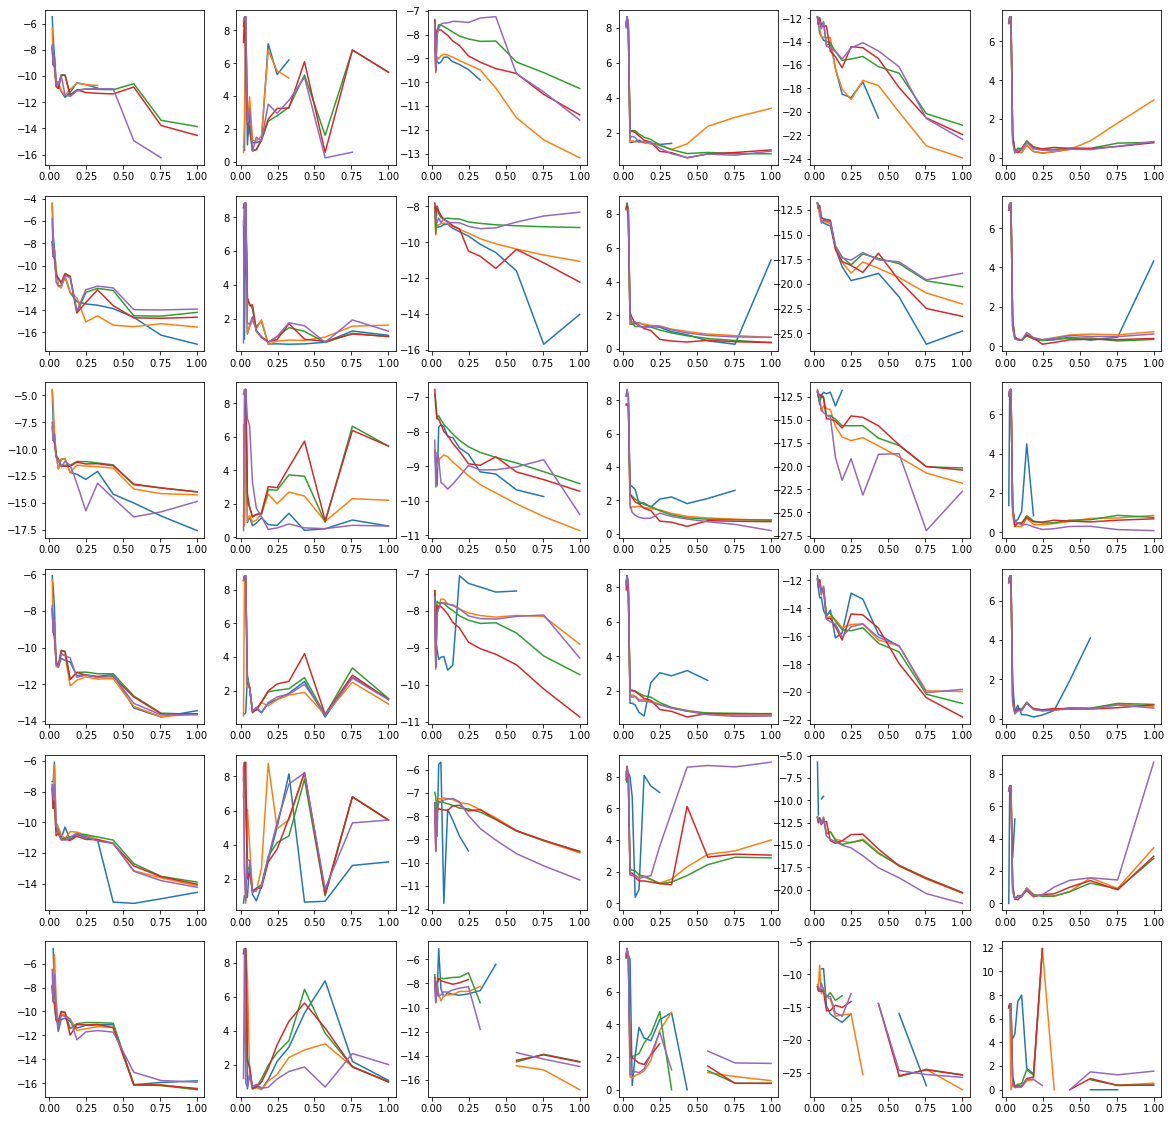

In [123]:
# Case 2
fig, ax = plt.subplots(6, 6, figsize=(20, 20))

kappa = 5
np_ratio = 2

for i, sm in enumerate(selection_methods):
    for j, bw in enumerate(betawidth):        
        for k, df in enumerate(df_names):
            df_ = apply_df_filters(sigmoid_exp_df, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                       betawidth=bw, df_name=df)
            xx = df_['sparsity'].values
            yy = np.array([df_['coef'].values[idx][2] for idx in range(df_.shape[0])])
            ax[i, 2*j].plot(xx, yy)
            yy = np.array([df_['coef'].values[idx][1] for idx in range(df_.shape[0])])
            ax[i, 2*j + 1].plot(xx, yy)

In [ ]:
# Takeaways

In [126]:
x = np.random.random((5, 5))

In [128]:
x

array([[0.79564904, 0.19331122, 0.71867533, 0.37151962, 0.13236838],
       [0.15333681, 0.94799887, 0.09860229, 0.03891568, 0.1131975 ],
       [0.82574762, 0.4013674 , 0.52752389, 0.79438634, 0.14080438],
       [0.24240877, 0.13272264, 0.60194486, 0.26187953, 0.99726374],
       [0.83131793, 0.48398666, 0.62348223, 0.54351011, 0.46959639]])

In [127]:
x[np.ix_([0, 1], [0, 1])]

array([[0.79564904, 0.19331122],
       [0.15333681, 0.94799887]])